In [2]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [3]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima.utils import decomposed_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import acf
from sklearn.preprocessing import MinMaxScaler

# Function to convert age range to a numerical value
def convertir_rango_edad_a_numero(rango_edad):
    return int(rango_edad // 3)

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to calculate various metrics from model results
def calculo_metricas(results):
    residuals = results.resid
    
    mae = np.mean(np.abs(residuals))
    result = acorr_ljungbox(residuals, period=52)
    mse = np.mean(residuals**2)
    rmse = np.sqrt(mse)
    p_value = round(result.lb_pvalue.mean(), 3)
    
    return mae, mse, rmse, results.aic, results.bic, p_value

# Function to create a summary table from model results
def summary_table(results):
    summary_table = results.summary().tables[1]
    
    # Convert the summary table to a DataFrame
    summary_df = pd.DataFrame(summary_table.data[1:], columns=summary_table.data[0])
    
    # Clean up the DataFrame
    summary_df = summary_df.apply(pd.to_numeric, errors='ignore')
    
    # Rename columns for better access
    summary_df.columns = ['variable', 'coef', 'std_err', 'z', 'P>|z|', '[0.025', '0.975]']
    
    return summary_table


In [4]:
df_f=pd.read_csv("Bases//Base_Limpia_Added.csv")

In [17]:
df_f["provincia"].unique()

df_c0=pd.read_csv("Bases//Base_Casos_Act.csv")


cols_clima=['salud',"densidad_estimada","index obesity","TEMP","HUM","PNM","DD","FF"]

# After a lot of runs the poverty data didnt improve the model, this could is probably because is not temporal data, it only refer to one moment of the census
cols_pobreza=['% de hogares sin acceso a red cloacal','% de población en situación de pobreza crónica','% de población sin obra social ni prepaga'] # Mejor
cols_pobreza=['% de hogares sin acceso a red cloacal','% de población en situación de pobreza crónica']
cols_pobreza=[ 'Nivel de incidencia de pobreza crónica','% de hogares con hacinamiento crítico','% de hogares en vivienda deficitaria','% de hogares sin acceso a red cloacal','% de población en situación de pobreza crónica','% de población sin obra social ni prepaga']
cols_pobreza=['% de hogares sin acceso a red cloacal','% de población en situación de pobreza crónica','% de población sin obra social ni prepaga'] # Mejor

cols_pobreza=[ 'Nivel de incidencia de pobreza crónica','% de hogares con hacinamiento crítico','% de hogares en vivienda deficitaria','% de hogares sin acceso a red cloacal','% de población en situación de pobreza crónica','% de población sin obra social ni prepaga']

cols_pobreza=[]
cols_pred=cols_clima+cols_pobreza

# Select the province or provinces for run the models
l_provincias=[]

l_provincias=["Santa Fe"]

l_provincias=["CABA"]





l_provincias=["Salta","Jujuy"]

l_provincias=["Buenos Aires","CABA"]

# ARIMA and SARIMAX Models

In [18]:
def pre_process(l_p, df_c0, df_f, cols_pred):
    """
    Pre-processes tuberculosis incidence and climate data for specific provinces.

    Input:
    - l_p (list): List of provinces to filter data. If empty, processes data for all provinces.
    - df_c0 (DataFrame): DataFrame containing COVID-19 data.
    - df_f (DataFrame): DataFrame containing climate and poverty data.
    - cols_pred (list): List of columns to use as predictors in the analysis.

    Output:
    - df_f2 (DataFrame): Processed DataFrame containing normalized climate and poverty data along with COVID-19 cases.
    - promedio_por_dia (DataFrame): DataFrame with daily averages of predictors.
    - promedio_por_semana (DataFrame): DataFrame with weekly averages of predictors.

    Steps:
    1. Filters data based on the provinces provided in `l_p` or uses all data if `l_p` is empty.
    2. Normalizes columns in `df_f` except 'fecha' using MinMaxScaler.
    3. Computes daily and weekly averages of predictors from `df_f`.
    4. Interpolates missing values in `df_f2`.
    """
    # Step 1: Filter data based on provinces
    if len(l_p) == 0:
        df_cc = df_c0.copy()
        df_f2 = df_f.copy()[cols_pred + ["fecha"]]
    else:
        df_cc = df_c0.loc[df_c0["provincia"].isin(l_p)]
        df_f2 = df_f.loc[df_f["provincia"].isin(l_p)][cols_pred + ["fecha"]]

    # Drop 'provincia' column
    df_cc.drop(["provincia"], axis=1, inplace=True)

    # Step 2: Normalize columns in df_f2 except 'fecha'
    columns_to_normalize = df_f2.columns.difference(['fecha'])
    scaler = MinMaxScaler()
    df_f2 = df_f2.copy()
    df_f2[columns_to_normalize] = scaler.fit_transform(df_f2[columns_to_normalize])
    df_f2['fecha'] = pd.to_datetime(df_f2['fecha'])

    # Step 3: Compute daily and weekly averages of predictors in df_f2
    promedio_por_dia = df_f2.groupby(df_f2['fecha'].dt.to_period('D'))[cols_pred].mean()
    promedio_por_semana = df_f2.groupby(df_f2['fecha'].dt.to_period('W-Mon'))[cols_pred].mean()

    # Step 4: Merge COVID-19 cases with climate and poverty data by week
    df_cc['fecha'] = pd.to_datetime(df_cc['fecha'])
    incidencia_por_semana2 = df_cc.groupby(df_cc['fecha'].dt.to_period('W-Mon'))['casos_corr_2'].sum()
    incidencia_por_semana2 = incidencia_por_semana2.reset_index()

    df_f2 = pd.merge(pd.DataFrame(incidencia_por_semana2, columns=["fecha", "casos_corr_2"]),
                     pd.DataFrame(promedio_por_semana), on="fecha", how="left")
    df_f2 = df_f2.rename(columns={"casos_corr_2": "Casos"})

    # Additional processing: Convert 'fecha' to datetime and interpolate missing values
    df_f2['fecha'] = pd.to_datetime(df_f2['fecha'].astype(str).str.split('/').str[0])
    df_f2 = df_f2.interpolate()

    return df_f2, promedio_por_dia, promedio_por_semana


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
def easy_models(df_f2, cols_pred, test_ratio=0.2):
    """
    Runs and evaluates multiple time series models on COVID-19 data with train-test split.
    Metrics are calculated based on test data.

    Input:
    - df_f2 (DataFrame): Processed DataFrame containing normalized climate, poverty, and COVID-19 case data.
    - cols_pred (list): List of columns used as predictors in the analysis.
    - test_size (float): Proportion of the dataset to include in the test split (default is 0.2).

    Output:
    - arima_results (str): Summary table of ARIMA model results.
    - arimax_results (str): Summary table of ARIMAX model results.
    - sarima_results (str): Summary table of SARIMA model results.
    - sarimax_results (str): Summary table of SARIMAX model results.
    - df_metrics (DataFrame): DataFrame containing evaluation metrics (MAE, MSE, RMSE, AIC, BIC, p-value) for each model.
    """
    split_index = int(len(df_f2) * (1 - test_ratio))
    train = df_f2.iloc[:split_index]
    test = df_f2.iloc[split_index:]
    
    # Function to calculate metrics for test data
    def calculate_test_metrics(model, test, exog=None):
        predictions = model.forecast(steps=len(test), exog=exog)
        mae = mean_absolute_error(test['Casos'], predictions)
        mse = mean_squared_error(test['Casos'], predictions)
        rmse = np.sqrt(mse)
        return mae, mse, rmse

    metrics = []
    
    # ARIMA model without exogenous variables
    model = sm.tsa.ARIMA(train['Casos'], order=(1, 1, 1))
    results = model.fit()
    print("ARIMA results")
    arima_results = summary_table(results)
    mae, mse, rmse = calculate_test_metrics(results, test)
    arima_metrics = [mae, mse, rmse, results.aic, results.bic, results.pvalues[0]]
    metrics.append(arima_metrics)

    # ARIMAX model with exogenous variables
    model = sm.tsa.ARIMA(train['Casos'], exog=train[cols_pred], order=(1, 1, 1))
    results = model.fit()
    print("ARIMAX results")
    arimax_results = summary_table(results)
    mae, mse, rmse = calculate_test_metrics(results, test, exog=test[cols_pred])
    arimax_metrics = [mae, mse, rmse, results.aic, results.bic, results.pvalues[0]]
    metrics.append(arimax_metrics)

    # Auto ARIMA model selection
    print("Auto model results")
    auto_model = auto_arima(train['Casos'], max_p=8, max_d=8, max_q=8)
    print(auto_model.summary())
    p_best, d_best, q_best = auto_model.order

    # SARIMA model
    order = (p_best, d_best, q_best)
    model = sm.tsa.SARIMAX(train['Casos'], order=order)
    results = model.fit()
    sarima_results = summary_table(results)
    print("SARIMA results")
    mae, mse, rmse = calculate_test_metrics(results, test)
    sarima_metrics = [mae, mse, rmse, results.aic, results.bic, results.pvalues[0]]
    metrics.append(sarima_metrics)

    # SARIMAX model with exogenous variables
    model = sm.tsa.SARIMAX(train['Casos'], order=order, exog=train[cols_pred])
    results = model.fit()
    sarimax_results = summary_table(results)
    print("SARIMAX results")
    mae, mse, rmse = calculate_test_metrics(results, test, exog=test[cols_pred])
    sarimax_metrics = [mae, mse, rmse, results.aic, results.bic, results.pvalues[0]]
    metrics.append(sarimax_metrics)

    # Combine metrics into DataFrame for easy comparison
    model_names = [
        "ARIMA (1,1,1)", 
        "ARIMAX (1,1,1)", 
        f"SARIMA ({p_best},{d_best},{q_best})", 
        f"SARIMAX ({p_best},{d_best},{q_best})"
    ]
    df_metrics = pd.DataFrame(metrics, columns=["mae", "mse", "rmse", "AIC", "BIC", "p-value"])
    df_metrics["Model Name"] = model_names

    return arima_results, arimax_results, sarima_results, sarimax_results, df_metrics
# Example usage:
for l_p in [l_provincias]:
    print(l_p)
    df_f2, promedio_dia, promedio_por_semana = pre_process(l_p, df_c0, df_f, cols_pred)
    arima_results, arimax_results, sarima_results, sarimax_results, df_metrics = easy_models(df_f2, cols_pred)

['Buenos Aires', 'CABA']
ARIMA results
ARIMAX results
Auto model results
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  584
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1653.478
Date:                Tue, 24 Dec 2024   AIC                           3314.957
Time:                        15:07:25   BIC                           3332.430
Sample:                             0   HQIC                          3321.768
                                - 584                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4472      0.040     11.043      0.000       0.368       0.527
ar.L2          0.1389      0.040      3.453      0.001    

In [21]:
best_rmse=df_metrics.loc[df_metrics["p-value"]<0.05]["rmse"].min()
best_rmse

5.387457781377993

In [22]:
def simple_table_to_df(simple_table):
    """
    Convert a simple table structure into a Pandas DataFrame.
    
    Parameters:
    - simple_table (object): A structured data object representing a table.
    
    Returns:
    - df (DataFrame): Pandas DataFrame containing the table data.
    """
    data = simple_table.data[1:]  # Skip the header row, assuming data starts from the second row
    headers = simple_table.data[0]  # Use the first row as headers
    
    # Create DataFrame with extracted data and headers
    df = pd.DataFrame(data, columns=headers)
    
    # Convert all columns to numeric (ignore errors if conversion fails)
    df = df.apply(pd.to_numeric, errors='ignore')
    
    return df

def best_variables(arimax_results, sarimax_results, best_sarimax):
    """
    Consolidates and compares coefficients and statistical significance (P-values) 
    of variables from different model results (ARIMAX, SARIMAX, and best-performing SARIMAX).

    Inputs:
    - arimax_results: Summary table or data structure from ARIMAX model results.
    - sarimax_results: Summary table or data structure from SARIMAX model results.
    - best_sarimax: Detailed results from the best-performing SARIMAX model.

    Outputs:
    - df_final: Pandas DataFrame with variables as rows and columns representing 
      coefficients (coef) and statistical significance (P>|z|) from ARIMAX, SARIMAX, 
      and best-performing SARIMAX models.
    """
    # Extract relevant columns from ARIMAX and SARIMAX results
    df1 = simple_table_to_df(arimax_results)[["", "coef", "P>|z|"]].add_suffix('_ARIMAX')
    df2 = simple_table_to_df(sarimax_results)[["", "coef", "P>|z|"]].add_suffix('_SARIMAX')
    
    # Extract relevant columns from best SARIMAX results
    df3 = simple_table_to_df(best_sarimax["results"])[["", "coef", "P>|z|"]].add_suffix('_SARIMAX_BEST')

    # Rename columns for merging and comparison
    df1 = df1.rename(columns={'_ARIMAX': 'variable'})
    df2 = df2.rename(columns={'_SARIMAX': 'variable'})
    df3 = df3.rename(columns={'_SARIMAX_BEST': 'variable'})

    # Merge DataFrames on 'variable' column
    df_final = pd.merge(df1, df2, on="variable", how="left")
    df_final = pd.merge(df_final, df3, on="variable", how="left")[:-3]  # Remove last 3 rows (assuming they are footer rows)

    # Filter final DataFrame based on significance levels
    df_final = df_final.loc[(df_final["P>|z|_ARIMAX"] < 0.15) | (df_final["P>|z|_SARIMAX"] < 0.05) | (df_final["P>|z|_SARIMAX_BEST"] < 0.15)]

    return df_final



In [ ]:
import warnings
warnings.filterwarnings("ignore")
def grid_search(df_f2, best_rmse, model_="SARIMAX"):
    """
    Performs a grid search to find the best SARIMA/SARIMAX model based on RMSE and p-value criteria.

    Input:
    - df_f2 (DataFrame): Processed DataFrame containing normalized climate, poverty, and COVID-19 case data.
    - best_rmse (float): Best RMSE value obtained from initial model evaluation.
    - model_ (str): Type of model to perform grid search ('SARIMAX' or 'ARIMA').

    Output:
    - df_best (DataFrame): DataFrame containing metrics and results of best-performing models from grid search.
    """
    l_metrics = []
    p, d, q = 4, 2, 4  # Define search ranges for p, d, q
    print(f"max p, d, q: {p}, {d}, {q}")

    # Perform grid search over defined parameter ranges
    for p_ in range(p):
        for d_ in range(d):
            for q_ in range(q):
                order = (p_, d_, q_)  # ARIMA/SARIMA order parameters

                try:
                    if model_ == "SARIMAX":
                        model = sm.tsa.SARIMAX(df_f2['Casos'], exog=df_f2[cols_pred], order=order)
                    elif model_ == "ARIMA":
                        model = sm.tsa.ARIMA(df_f2['Casos'], exog=df_f2[cols_pred], order=order)

                    results = model.fit()
                    results.fittedvalues[0] = results.fittedvalues.mean()  # Adjust first fitted value

                    # Calculate metrics
                    mae, mse, rmse, aic, bic, p_value = calculo_metricas(results)

                    # Store results if RMSE is lower than current best and p-value is significant
                    if (rmse <= best_rmse) and (p_value<0.05):
                        best_results = summary_table(results)
                        # display(best_results)
                        print(p_, d_, q_)
                        # if p_value < 0.06:
                        #     print(results.summary())
                        print(mae, mse, rmse, aic, bic, p_value)
                        values = (p_, d_, q_, mae, mse, rmse, aic, bic, p_value, best_results)
                        l_metrics.append(values)

                except:
                    print("Error encountered in model fitting")

    # Create DataFrame from collected metrics and results
    df_best = pd.DataFrame(l_metrics)
    df_best["NAME"] = "SARIMAX ("+df_best[0].astype(str) +", "+df_best[1].astype(str) +", "+df_best[2].astype(str)+" )"

    df_best.drop([0, 1, 2], axis=1, inplace=True)
    df_best.columns = ["mae", "mse", "rmse", "AIC", "BIC", "p-value", "results", "Model Name"]

    return df_best

def best_sarimax(df_metrics, model_):
    """
    Identifies the best SARIMA/SARIMAX model based on p-value and RMSE criteria.

    Input:
    - df_metrics (DataFrame): DataFrame containing evaluation metrics for multiple SARIMA/SARIMAX models.
    - model_ (str): Type of model to consider ('SARIMAX' or 'ARIMA').

    Output:
    - df_metrics (DataFrame): Updated DataFrame with details of the best-performing SARIMA/SARIMAX model.
    - df_best (DataFrame): DataFrame containing metrics and results of best-performing models.
    """
    # Display metrics for models with p-value < 0.05
    display(df_metrics[df_metrics["p-value"] < 0.05])

    # Find the best RMSE among models with significant p-value
    best_rmse = df_metrics.loc[df_metrics["p-value"] < 0.05]["rmse"].min()

    # Perform grid search to find best model based on updated RMSE criteria
    df_best = grid_search(df_f2, best_rmse, model_)

    # Identify the best SARIMAX model with p-value < 0.06 and lowest RMSE
    best_sarimax = df_best.loc[df_best["p-value"] < 0.06].sort_values(by="rmse").iloc[0]

    # Append best SARIMAX model details to df_metrics and round values for clarity
    df_metrics.loc[-1] = best_sarimax
    df_metrics = df_metrics.reset_index(drop=True).round(2)

    return df_metrics, df_best


# Filter df_metrics to select rows where the model name starts with "SARIMAX"
# and the p-value is less than or equal to 0.1, indicating statistical significance.
sarimax_true = df_metrics.loc[(df_metrics["Model Name"].str[:7] == "SARIMAX") & (df_metrics["p-value"] <= 0.1)]

# Specify the model type to focus on for further analysis and comparison.
model_best = "SARIMAX"

# Call the function best_sarimax to identify and extract the best-performing SARIMAX model
# from df_metrics based on predefined criteria.
df_metrics_, df_best = best_sarimax(df_metrics, model_best)


,mae,mse,rmse,AIC,BIC,p-value,Model Name
0,4.478625,29.024701,5.387458,3322.312737,3335.417298,2.411941e-29,"ARIMA (1,1,1)"
2,4.562956,29.512008,5.432496,3314.956982,3332.429731,2.372121e-28,"SARIMA (2,1,1)"


max p, d, q: 4, 2, 4


,coef,std err,z,P>|z|,[0.025,0.975]
salud,15.5069,7.464,2.078,0.038,0.878,30.136
densidad_estimada,37.7499,4.313,8.753,0.000,29.297,46.203
index obesity,14.5478,1.231,11.821,0.000,12.136,16.960
TEMP,-1.1008,1.803,-0.610,0.542,-4.635,2.434
HUM,-0.8240,2.724,-0.302,0.762,-6.163,4.515
PNM,-0.4205,3.149,-0.134,0.894,-6.592,5.751
DD,-4.8912,3.236,-1.511,0.131,-11.234,1.451
FF,15.3198,4.221,3.630,0.000,7.048,23.592
sigma2,23.5595,1.278,18.432,0.000,21.054,26.065


0 0 0
3.905527228160933 23.55939972731567 4.853802604898109 4402.100822821116 4443.450543958864 0.0


,coef,std err,z,P>|z|,[0.025,0.975]
salud,17.8062,6.674,2.668,0.008,4.726,30.886
densidad_estimada,21.6415,3.805,5.688,0.000,14.184,29.099
index obesity,15.1700,1.433,10.585,0.000,12.361,17.979
TEMP,0.4919,1.865,0.264,0.792,-3.163,4.146
HUM,1.4780,2.700,0.547,0.584,-3.814,6.770
PNM,-2.4161,2.920,-0.827,0.408,-8.140,3.307
DD,0.6839,2.790,0.245,0.806,-4.785,6.152
FF,11.8536,4.039,2.935,0.003,3.937,19.770
ma.L1,0.3749,0.034,11.128,0.000,0.309,0.441
sigma2,19.7153,1.018,19.363,0.000,17.720,21.711


0 0 1
3.4920593975858525 19.72078678166303 4.440809248511248 4274.064221445133 4320.00835604263 0.0


,coef,std err,z,P>|z|,[0.025,0.975]
salud,16.5330,5.851,2.826,0.005,5.065,28.001
densidad_estimada,26.7070,3.577,7.466,0.000,19.696,33.718
index obesity,16.5420,1.585,10.435,0.000,13.435,19.649
TEMP,0.4279,1.952,0.219,0.826,-3.397,4.253
HUM,1.2816,2.493,0.514,0.607,-3.605,6.168
PNM,-0.9900,2.519,-0.393,0.694,-5.927,3.947
DD,-0.4919,2.529,-0.195,0.846,-5.448,4.464
FF,8.7912,4.061,2.165,0.030,0.831,16.751
ma.L1,0.3683,0.035,10.504,0.000,0.300,0.437
ma.L2,0.3289,0.036,9.196,0.000,0.259,0.399


0 0 2
3.2649894821939283 17.14623075183913 4.140800738002148 4173.876483011471 4224.415031068718 0.0


,coef,std err,z,P>|z|,[0.025,0.975]
salud,12.5215,5.650,2.216,0.027,1.448,23.595
densidad_estimada,26.2321,3.520,7.452,0.000,19.333,33.131
index obesity,17.3538,1.754,9.892,0.000,13.915,20.792
TEMP,0.3963,1.996,0.199,0.843,-3.516,4.308
HUM,0.3969,2.569,0.154,0.877,-4.639,5.432
PNM,-0.2792,2.633,-0.106,0.916,-5.440,4.881
DD,-2.2490,2.571,-0.875,0.382,-7.289,2.791
FF,11.9450,3.765,3.172,0.002,4.565,19.325
ma.L1,0.3752,0.036,10.389,0.000,0.304,0.446
ma.L2,0.3899,0.038,10.336,0.000,0.316,0.464


0 0 3
3.141015684779175 16.129186308322367 4.016115823569132 4131.199784401075 4186.332745918072 0.002


,coef,std err,z,P>|z|,[0.025,0.975]
salud,6.1908,6.310,0.981,0.327,-6.176,18.558
densidad_estimada,16.4804,3.912,4.212,0.000,8.812,24.149
index obesity,4.9395,8.250,0.599,0.549,-11.231,21.110
TEMP,-2.5579,3.514,-0.728,0.467,-9.446,4.330
HUM,0.3817,2.553,0.150,0.881,-4.621,5.385
PNM,-3.5044,2.114,-1.658,0.097,-7.647,0.638
DD,0.2511,2.322,0.108,0.914,-4.301,4.803
FF,0.4235,3.441,0.123,0.902,-6.320,7.167
sigma2,19.2490,0.799,24.086,0.000,17.683,20.815


0 1 0
3.3269160306726206 19.372288068948198 4.401396149967439 4248.597105782001 4289.934506589282 0.0


,coef,std err,z,P>|z|,[0.025,0.975]
salud,3.4023,7.025,0.484,0.628,-10.367,17.172
densidad_estimada,25.5408,4.314,5.921,0.000,17.086,33.996
index obesity,12.8107,8.485,1.510,0.131,-3.820,29.441
TEMP,-1.6386,3.005,-0.545,0.586,-7.528,4.251
HUM,0.2099,2.811,0.075,0.940,-5.299,5.719
PNM,-3.0321,2.493,-1.216,0.224,-7.919,1.855
DD,-2.7496,2.595,-1.060,0.289,-7.835,2.336
FF,2.9494,3.888,0.759,0.448,-4.671,10.570
ma.L1,-0.5213,0.029,-17.789,0.000,-0.579,-0.464
sigma2,15.7592,0.690,22.847,0.000,14.407,17.111


0 1 1
3.056655046270901 15.834184469271857 3.9792190778181413 4106.222171188567 4152.152616529991 0.007


,coef,std err,z,P>|z|,[0.025,0.975]
salud,6.0369,7.178,0.841,0.400,-8.032,20.106
densidad_estimada,21.3316,4.441,4.804,0.000,12.628,30.035
index obesity,6.5284,8.552,0.763,0.445,-10.234,23.291
TEMP,-0.7418,2.606,-0.285,0.776,-5.850,4.367
HUM,-0.8628,2.710,-0.318,0.750,-6.174,4.448
PNM,-2.5874,2.501,-1.035,0.301,-7.489,2.314
DD,-3.0090,2.525,-1.192,0.233,-7.958,1.940
FF,2.8130,3.892,0.723,0.470,-4.816,10.442
ma.L1,-0.5418,0.032,-16.753,0.000,-0.605,-0.478
ma.L2,-0.1348,0.033,-4.077,0.000,-0.200,-0.070


0 1 2
3.051449457762457 15.763928796136002 3.97038144214583 4103.17819762234 4153.701687497907 0.003


,coef,std err,z,P>|z|,[0.025,0.975]
salud,7.0303,6.902,1.019,0.308,-6.496,20.557
densidad_estimada,22.0591,4.392,5.022,0.000,13.450,30.668
index obesity,4.4085,8.359,0.527,0.598,-11.974,20.791
TEMP,-0.5428,2.167,-0.251,0.802,-4.789,3.704
HUM,-0.8190,2.585,-0.317,0.751,-5.886,4.248
PNM,-1.6787,2.404,-0.698,0.485,-6.391,3.034
DD,-3.4459,2.441,-1.412,0.158,-8.229,1.338
FF,2.0690,3.816,0.542,0.588,-5.409,9.547
ma.L1,-0.5902,0.033,-17.721,0.000,-0.655,-0.525
ma.L2,-0.0132,0.041,-0.321,0.748,-0.094,0.067


0 1 3
2.9869984811279022 15.117331690381752 3.8881012963118327 4074.051102963431 4129.16763737314 0.006


,coef,std err,z,P>|z|,[0.025,0.975]
salud,17.3514,5.851,2.966,0.003,5.884,28.819
densidad_estimada,18.8787,3.393,5.564,0.000,12.229,25.529
index obesity,21.1104,2.084,10.129,0.000,17.026,25.195
TEMP,0.9510,2.345,0.405,0.685,-3.646,5.548
HUM,0.8937,2.540,0.352,0.725,-4.085,5.872
PNM,-1.6782,2.385,-0.704,0.482,-6.353,2.996
DD,0.3415,2.350,0.145,0.884,-4.265,4.948
FF,5.2477,3.641,1.441,0.150,-1.889,12.384
ar.L1,0.6327,0.028,22.606,0.000,0.578,0.688
sigma2,16.3031,0.771,21.152,0.000,14.793,17.814


1 0 0
3.137764435645216 16.29218503243385 4.036357892015257 4134.662000839 4180.606135436497 0.0


,coef,std err,z,P>|z|,[0.025,0.975]
salud,11.8091,6.310,1.872,0.061,-0.558,24.176
densidad_estimada,24.8983,3.825,6.509,0.000,17.401,32.395
index obesity,24.8930,2.573,9.676,0.000,19.851,29.935
TEMP,-0.4875,2.694,-0.181,0.856,-5.769,4.794
HUM,0.8605,2.671,0.322,0.747,-4.375,6.096
PNM,-1.9027,2.448,-0.777,0.437,-6.701,2.895
DD,-1.9064,2.543,-0.750,0.453,-6.890,3.078
FF,5.0758,3.784,1.341,0.180,-2.341,12.493
ar.L1,0.8729,0.025,34.270,0.000,0.823,0.923
ma.L1,-0.4110,0.046,-8.957,0.000,-0.501,-0.321


1 0 1
3.0135356882591116 15.081004783528321 3.883426938095826 4080.4462999571756 4130.984848014423 0.01


,coef,std err,z,P>|z|,[0.025,0.975]
salud,12.2335,6.020,2.032,0.042,0.435,24.032
densidad_estimada,25.9454,3.729,6.958,0.000,18.637,33.253
index obesity,24.2228,2.424,9.992,0.000,19.472,28.974
TEMP,0.0863,2.588,0.033,0.973,-4.986,5.159
HUM,0.7769,2.632,0.295,0.768,-4.382,5.936
PNM,-1.7302,2.413,-0.717,0.473,-6.460,3.000
DD,-2.4444,2.531,-0.966,0.334,-7.404,2.515
FF,5.4447,3.723,1.463,0.144,-1.851,12.741
ar.L1,0.8108,0.036,22.606,0.000,0.740,0.881
ma.L1,-0.3702,0.047,-7.863,0.000,-0.462,-0.278


1 0 2
2.997735890133045 14.970940477831173 3.869229959285332 4077.026595809136 4132.159557326133 0.045


,coef,std err,z,P>|z|,[0.025,0.975]
salud,9.5518,6.491,1.472,0.141,-3.170,22.274
densidad_estimada,27.2022,4.048,6.721,0.000,19.269,35.135
index obesity,24.5049,2.913,8.412,0.000,18.795,30.215
TEMP,-0.3481,2.517,-0.138,0.890,-5.281,4.585
HUM,1.5677,2.619,0.599,0.549,-3.566,6.701
PNM,-0.8025,2.430,-0.330,0.741,-5.566,3.961
DD,-3.4082,2.589,-1.316,0.188,-8.482,1.666
FF,4.5885,3.957,1.160,0.246,-3.167,12.344
ar.L1,0.9484,0.021,45.050,0.000,0.907,0.990
ma.L1,-0.5477,0.040,-13.628,0.000,-0.626,-0.469


1 0 3
2.9942907321505667 14.91381541952659 3.8618409365905517 4076.4485377774836 4136.175912754231 0.019


,coef,std err,z,P>|z|,[0.025,0.975]
salud,3.6191,6.709,0.539,0.590,-9.530,16.769
densidad_estimada,25.1773,4.259,5.911,0.000,16.829,33.525
index obesity,9.0186,8.698,1.037,0.300,-8.028,26.065
TEMP,-1.3243,3.218,-0.412,0.681,-7.631,4.983
HUM,-0.3478,2.848,-0.122,0.903,-5.929,5.234
PNM,-1.6748,2.411,-0.695,0.487,-6.401,3.051
DD,-2.7127,2.602,-1.043,0.297,-7.812,2.387
FF,1.7102,3.847,0.445,0.657,-5.829,9.249
ar.L1,-0.4203,0.032,-13.097,0.000,-0.483,-0.357
sigma2,16.3969,0.725,22.619,0.000,14.976,17.818


1 1 0
3.0816477041208734 16.314249922041903 4.039090234451553 4126.9151936554645 4172.845638996889 0.002


,coef,std err,z,P>|z|,[0.025,0.975]
salud,6.1147,6.851,0.892,0.372,-7.314,19.543
densidad_estimada,19.0600,4.211,4.526,0.000,10.806,27.314
index obesity,4.5256,7.972,0.568,0.570,-11.099,20.150
TEMP,-0.8852,2.113,-0.419,0.675,-5.027,3.257
HUM,-1.3745,2.545,-0.540,0.589,-6.362,3.613
PNM,-2.5553,2.412,-1.059,0.289,-7.283,2.172
DD,-2.5236,2.363,-1.068,0.285,-7.154,2.107
FF,2.4013,3.601,0.667,0.505,-4.656,9.459
ar.L1,0.4360,0.040,10.850,0.000,0.357,0.515
ma.L1,-0.9110,0.020,-46.251,0.000,-0.950,-0.872


1 1 1
2.995690423851077 15.26722823633098 3.907330064933212 4078.503876290517 4129.027366166084 0.001


,coef,std err,z,P>|z|,[0.025,0.975]
salud,5.8687,6.719,0.873,0.382,-7.300,19.038
densidad_estimada,21.1621,4.128,5.126,0.000,13.070,29.254
index obesity,6.1495,7.534,0.816,0.414,-8.616,20.915
TEMP,-1.3949,2.304,-0.606,0.545,-5.910,3.120
HUM,-0.9011,2.627,-0.343,0.732,-6.051,4.249
PNM,-2.1194,2.474,-0.857,0.392,-6.969,2.730
DD,-2.5907,2.503,-1.035,0.301,-7.497,2.316
FF,2.4818,3.633,0.683,0.494,-4.638,9.602
ar.L1,0.7479,0.050,14.858,0.000,0.649,0.847
ma.L1,-1.2763,0.066,-19.198,0.000,-1.407,-1.146


1 1 2
2.96238697772005 14.83761648939618 3.85196268016659 4060.5880069912682 4115.704541400977 0.008


,coef,std err,z,P>|z|,[0.025,0.975]
salud,6.9324,6.495,1.067,0.286,-5.798,19.663
densidad_estimada,22.0651,4.128,5.345,0.000,13.974,30.156
index obesity,4.5844,7.725,0.593,0.553,-10.556,19.725
TEMP,-0.8063,2.160,-0.373,0.709,-5.039,3.427
HUM,-0.8362,2.596,-0.322,0.747,-5.925,4.253
PNM,-1.4611,2.432,-0.601,0.548,-6.228,3.306
DD,-2.9122,2.482,-1.173,0.241,-7.776,1.952
FF,1.4152,3.566,0.397,0.691,-5.575,8.405
ar.L1,0.5928,0.079,7.506,0.000,0.438,0.748
ma.L1,-1.1740,0.083,-14.158,0.000,-1.336,-1.011


1 1 3
2.9284105926465784 14.598981625446184 3.8208613721837885 4050.407715605489 4110.117294549341 0.042


,coef,std err,z,P>|z|,[0.025,0.975]
salud,12.2094,5.992,2.037,0.042,0.465,23.954
densidad_estimada,26.2073,3.724,7.038,0.000,18.909,33.506
index obesity,23.1579,2.397,9.663,0.000,18.461,27.855
TEMP,0.2823,2.553,0.111,0.912,-4.722,5.286
HUM,0.6995,2.617,0.267,0.789,-4.429,5.828
PNM,-1.2484,2.411,-0.518,0.605,-5.975,3.478
DD,-1.3574,2.520,-0.539,0.590,-6.297,3.582
FF,4.6172,3.801,1.215,0.224,-2.833,12.067
ar.L1,0.4364,0.033,13.302,0.000,0.372,0.501
ar.L2,0.3060,0.034,9.121,0.000,0.240,0.372


2 0 0
3.003320575670389 14.975568444985013 3.8698279606443764 4075.1971767689956 4125.735724826243 0.037


,coef,std err,z,P>|z|,[0.025,0.975]
salud,12.1334,6.033,2.011,0.044,0.310,23.957
densidad_estimada,26.3845,3.762,7.013,0.000,19.011,33.758
index obesity,24.2560,2.442,9.934,0.000,19.470,29.042
TEMP,0.0419,2.583,0.016,0.987,-5.021,5.104
HUM,0.8414,2.621,0.321,0.748,-4.296,5.978
PNM,-1.6762,2.402,-0.698,0.485,-6.385,3.032
DD,-2.1724,2.534,-0.857,0.391,-7.139,2.794
FF,5.0659,3.787,1.338,0.181,-2.356,12.488
ar.L1,0.5100,0.115,4.435,0.000,0.285,0.735
ar.L2,0.2670,0.079,3.368,0.001,0.112,0.422


2 0 1
3.0022020219796413 14.967265025338868 3.868754970961442 4076.8290340822114 4131.961995599208 0.041


,coef,std err,z,P>|z|,[0.025,0.975]
salud,12.0704,6.184,1.952,0.051,-0.050,24.191
densidad_estimada,26.7383,3.820,7.000,0.000,19.251,34.225
index obesity,24.6535,2.496,9.878,0.000,19.762,29.545
TEMP,-0.2866,2.631,-0.109,0.913,-5.443,4.870
HUM,0.3144,2.645,0.119,0.905,-4.870,5.499
PNM,-1.9585,2.402,-0.815,0.415,-6.666,2.749
DD,-2.9965,2.568,-1.167,0.243,-8.029,2.036
FF,6.2280,3.842,1.621,0.105,-1.302,13.758
ar.L1,0.3163,0.282,1.123,0.262,-0.236,0.868
ar.L2,0.4513,0.255,1.770,0.077,-0.048,0.951


2 0 2
3.004354786133936 14.973826352912026 3.869602867596625 4079.1790072919925 4138.906382268739 0.037


,coef,std err,z,P>|z|,[0.025,0.975]
salud,12.0223,5.980,2.010,0.044,0.302,23.743
densidad_estimada,27.0826,3.731,7.260,0.000,19.771,34.394
index obesity,22.9448,2.372,9.672,0.000,18.295,27.595
TEMP,-0.4908,2.556,-0.192,0.848,-5.501,4.519
HUM,-0.0046,2.626,-0.002,0.999,-5.152,5.143
PNM,-1.5199,2.437,-0.624,0.533,-6.297,3.257
DD,-3.3326,2.597,-1.283,0.199,-8.422,1.757
FF,8.1453,3.767,2.162,0.031,0.761,15.529
ar.L1,0.9062,3.096,0.293,0.770,-5.163,6.975
ar.L2,-0.0882,2.427,-0.036,0.971,-4.844,4.668


2 0 3
2.9986047644745595 14.98421292467879 3.8709447070035488 4081.6414953551403 4145.963283791637 0.046


,coef,std err,z,P>|z|,[0.025,0.975]
salud,4.9209,6.804,0.723,0.470,-8.414,18.256
densidad_estimada,23.2816,4.319,5.391,0.000,14.817,31.746
index obesity,7.7914,8.601,0.906,0.365,-9.066,24.649
TEMP,-0.8332,3.180,-0.262,0.793,-7.065,5.399
HUM,-0.3714,2.882,-0.129,0.897,-6.019,5.277
PNM,-2.0692,2.497,-0.829,0.407,-6.963,2.825
DD,-2.3707,2.590,-0.915,0.360,-7.448,2.706
FF,1.6387,3.774,0.434,0.664,-5.758,9.035
ar.L1,-0.4608,0.034,-13.469,0.000,-0.528,-0.394
ar.L2,-0.1184,0.037,-3.188,0.001,-0.191,-0.046


2 1 0
3.061520090905615 16.09679662514251 4.012081333315977 4118.93765233866 4169.461142214227 0.016


,coef,std err,z,P>|z|,[0.025,0.975]
salud,6.7155,6.612,1.016,0.310,-6.244,19.675
densidad_estimada,21.8428,4.165,5.245,0.000,13.680,30.005
index obesity,5.0693,7.613,0.666,0.506,-9.853,19.991
TEMP,-0.7932,2.254,-0.352,0.725,-5.212,3.625
HUM,-0.8425,2.623,-0.321,0.748,-5.983,4.298
PNM,-1.6237,2.447,-0.664,0.507,-6.420,3.172
DD,-3.1090,2.502,-1.243,0.214,-8.012,1.794
FF,1.8343,3.635,0.505,0.614,-5.290,8.959
ar.L1,0.3972,0.036,11.172,0.000,0.328,0.467
ar.L2,0.2248,0.036,6.185,0.000,0.154,0.296


2 1 1
2.942878959049846 14.688617438607537 3.832573213730892 4053.110948064429 4108.227482474138 0.031


,coef,std err,z,P>|z|,[0.025,0.975]
salud,7.4515,6.606,1.128,0.259,-5.496,20.399
densidad_estimada,21.5917,4.177,5.170,0.000,13.406,29.778
index obesity,4.4671,7.674,0.582,0.560,-10.574,19.508
TEMP,-1.1053,2.236,-0.494,0.621,-5.487,3.277
HUM,-0.5983,2.622,-0.228,0.819,-5.737,4.540
PNM,-2.5128,2.430,-1.034,0.301,-7.276,2.250
DD,-2.4772,2.497,-0.992,0.321,-7.370,2.416
FF,1.1382,3.657,0.311,0.756,-6.030,8.306
ar.L1,0.3535,0.165,2.142,0.032,0.030,0.677
ar.L2,0.2436,0.087,2.806,0.005,0.073,0.414


2 1 2
2.9430960420018946 14.707983836146887 3.83509893433623 4055.3162447286263 4115.025823672478 0.031


,coef,std err,z,P>|z|,[0.025,0.975]
salud,11.9368,6.081,1.963,0.050,0.018,23.856
densidad_estimada,26.0809,3.786,6.888,0.000,18.660,33.502
index obesity,23.5121,2.450,9.597,0.000,18.711,28.314
TEMP,0.1483,2.591,0.057,0.954,-4.930,5.227
HUM,0.7705,2.649,0.291,0.771,-4.422,5.963
PNM,-1.3269,2.441,-0.544,0.587,-6.110,3.457
DD,-1.3810,2.540,-0.544,0.587,-6.359,3.597
FF,4.5522,3.796,1.199,0.230,-2.888,11.992
ar.L1,0.4302,0.034,12.581,0.000,0.363,0.497
ar.L2,0.2909,0.038,7.746,0.000,0.217,0.365


3 0 0
2.9992797122588115 14.959873141613315 3.8677995219004453 4076.452731782679 4131.585693299677 0.042


,coef,std err,z,P>|z|,[0.025,0.975]
salud,11.6326,6.457,1.802,0.072,-1.023,24.288
densidad_estimada,25.3868,3.944,6.437,0.000,17.657,33.117
index obesity,24.6375,2.983,8.259,0.000,18.790,30.484
TEMP,-0.5427,2.379,-0.228,0.820,-5.205,4.120
HUM,0.1978,2.594,0.076,0.939,-4.886,5.282
PNM,-2.3680,2.389,-0.991,0.322,-7.050,2.314
DD,-2.6454,2.540,-1.042,0.298,-7.624,2.333
FF,3.8011,3.682,1.032,0.302,-3.416,11.018
ar.L1,1.3139,0.073,17.882,0.000,1.170,1.458
ar.L2,-0.1449,0.058,-2.497,0.013,-0.259,-0.031


3 0 1
2.964946518079625 14.710576146088401 3.8354368911622574 4066.4596600221244 4126.187034998871 0.03


,coef,std err,z,P>|z|,[0.025,0.975]
salud,12.3096,6.168,1.996,0.046,0.220,24.400
densidad_estimada,27.1188,3.818,7.104,0.000,19.636,34.601
index obesity,24.1372,2.452,9.842,0.000,19.330,28.944
TEMP,-0.3309,2.601,-0.127,0.899,-5.429,4.767
HUM,0.3924,2.658,0.148,0.883,-4.817,5.602
PNM,-1.6994,2.422,-0.702,0.483,-6.447,3.048
DD,-2.9427,2.593,-1.135,0.256,-8.025,2.140
FF,6.3218,3.834,1.649,0.099,-1.193,13.837
ar.L1,-0.0337,1.081,-0.031,0.975,-2.153,2.086
ar.L2,0.6054,0.508,1.192,0.233,-0.390,1.601


3 0 2
3.0044934274485815 14.965744941539338 3.868558509514796 4080.7599892819535 4145.08177771845 0.04


,coef,std err,z,P>|z|,[0.025,0.975]
salud,10.7726,6.569,1.640,0.101,-2.102,23.647
densidad_estimada,26.3121,4.091,6.432,0.000,18.294,34.330
index obesity,24.3019,5.134,4.733,0.000,14.239,34.365
TEMP,-1.8093,2.309,-0.784,0.433,-6.334,2.716
HUM,-1.5929,2.588,-0.616,0.538,-6.665,3.479
PNM,-2.4820,2.358,-1.053,0.293,-7.104,2.139
DD,-4.5586,2.529,-1.803,0.071,-9.515,0.397
FF,8.2990,3.700,2.243,0.025,1.047,15.551
ar.L1,1.0374,0.178,5.827,0.000,0.688,1.386
ar.L2,0.4371,0.326,1.341,0.180,-0.202,1.076


3 0 3
2.9586756345805694 14.68430998057338 3.8320112187431525 4069.7199600212507 4138.636161917498 0.026


,coef,std err,z,P>|z|,[0.025,0.975]
salud,5.4359,6.916,0.786,0.432,-8.119,18.991
densidad_estimada,23.5525,4.362,5.399,0.000,15.002,32.103
index obesity,7.3391,8.639,0.850,0.396,-9.593,24.271
TEMP,-0.8050,3.163,-0.255,0.799,-7.004,5.394
HUM,-0.6071,2.864,-0.212,0.832,-6.220,5.005
PNM,-1.9527,2.477,-0.788,0.430,-6.807,2.901
DD,-2.8068,2.591,-1.083,0.279,-7.885,2.271
FF,2.5414,3.880,0.655,0.512,-5.063,10.145
ar.L1,-0.4733,0.034,-13.903,0.000,-0.540,-0.407
ar.L2,-0.1471,0.042,-3.507,0.000,-0.229,-0.065


3 1 0
3.05679182599556 16.03393942348205 4.004240180543875 4118.260927857033 4173.3774622667415 0.023


,coef,std err,z,P>|z|,[0.025,0.975]
salud,7.0911,6.541,1.084,0.278,-5.730,19.912
densidad_estimada,21.3565,4.146,5.151,0.000,13.230,29.483
index obesity,4.6936,7.637,0.615,0.539,-10.274,19.661
TEMP,-1.1338,2.216,-0.512,0.609,-5.476,3.209
HUM,-0.7126,2.596,-0.275,0.784,-5.800,4.375
PNM,-2.2289,2.404,-0.927,0.354,-6.941,2.483
DD,-2.6401,2.470,-1.069,0.285,-7.480,2.200
FF,1.2641,3.628,0.348,0.728,-5.846,8.374
ar.L1,0.4022,0.036,11.167,0.000,0.332,0.473
ar.L2,0.2291,0.039,5.857,0.000,0.152,0.306


3 1 1
2.9412460942219796 14.70477455509834 3.83468050234936 4055.169351549203 4114.878930493054 0.032


,coef,std err,z,P>|z|,[0.025,0.975]
salud,6.7300,6.735,0.999,0.318,-6.470,19.930
densidad_estimada,22.1585,4.227,5.242,0.000,13.873,30.444
index obesity,5.2353,7.492,0.699,0.485,-9.449,19.920
TEMP,-0.8390,2.285,-0.367,0.713,-5.317,3.639
HUM,-0.6637,2.591,-0.256,0.798,-5.742,4.414
PNM,-1.7716,2.537,-0.698,0.485,-6.744,3.200
DD,-2.9455,2.604,-1.131,0.258,-8.050,2.159
FF,1.4335,3.568,0.402,0.688,-5.559,8.426
ar.L1,-0.5958,0.035,-16.782,0.000,-0.665,-0.526
ar.L2,0.6191,0.043,14.414,0.000,0.535,0.703


3 1 2
2.930618204639495 14.602561295721781 3.821329781073832 4052.7592115337357 4117.06183501173 0.032


In [24]:
df_metrics_

,mae,mse,rmse,AIC,BIC,p-value,Model Name
0,4.48,29.02,5.39,3322.31,3335.42,0.00,"ARIMA (1,1,1)"
1,4.83,32.88,5.73,3244.45,3292.50,0.98,"ARIMAX (1,1,1)"
2,4.56,29.51,5.43,3314.96,3332.43,0.00,"SARIMA (2,1,1)"
3,5.60,43.97,6.63,3226.22,3278.64,0.90,"SARIMAX (2,1,1)"
4,2.93,14.60,3.82,4050.41,4110.12,0.04,"SARIMAX (1, 1, 3 )"


In [25]:
# Save df_metrics DataFrame to a CSV file with a filename based on l_provincias
df_metrics_.to_csv("Resultados\\Tseries_Metricas" + str(l_provincias) + ".csv", index=False)

# Extract the detailed results DataFrame of the best-performing model (last row in df_best) and format it
df_variables = pd.DataFrame(df_best.iloc[-1]["results"])

# Rename the first column to "variable" and set it as the header row
df_variables[0].iloc[0] = "variable"
df_variables.columns = df_variables.iloc[0]

# Remove the first row (header row) to keep only the data rows
df_variables = df_variables[1:]
df_variables.columns=['variable','coef','std err','z','P>|z|','[0.025','0.975]']

df_variables

,variable,coef,std err,z,P>|z|,[0.025,0.975]
1,salud,6.7300,6.735,0.999,0.318,-6.470,19.930
2,densidad_estimada,22.1585,4.227,5.242,0.000,13.873,30.444
3,index obesity,5.2353,7.492,0.699,0.485,-9.449,19.920
4,TEMP,-0.8390,2.285,-0.367,0.713,-5.317,3.639
5,HUM,-0.6637,2.591,-0.256,0.798,-5.742,4.414
6,PNM,-1.7716,2.537,-0.698,0.485,-6.744,3.200
7,DD,-2.9455,2.604,-1.131,0.258,-8.050,2.159
8,FF,1.4335,3.568,0.402,0.688,-5.559,8.426
9,ar.L1,-0.5958,0.035,-16.782,0.000,-0.665,-0.526
10,ar.L2,0.6191,0.043,14.414,0.000,0.535,0.703


In [ ]:
for c in df_variables.columns[1:]:
    df_variables[c]=df_variables[c].astype(str).astype(float)
# Save df_variables DataFrame to a CSV file with a filename based on l_provincias
df_variables.to_csv("Resultados\\Tseries_Variables" + str(l_provincias) + ".csv", index=False)
df_variables.to_excel("Resultados\\Tseries_Variables" + str(l_provincias) + ".xlsx", index=False)

In [17]:
# Read the variables DataFrame from the CSV file and round numeric values to two decimal places
df_variables = pd.read_csv("Resultados\\Tseries_Variables" + str(l_provincias) + ".csv").round(2)

# Check if there is an 'Unnamed: 0' column in df_variables and drop it if present
if "Unnamed: 0" in df_variables.columns:
    df_variables.drop("Unnamed: 0", axis=1, inplace=True)

# Read the metrics DataFrame from the CSV file and round numeric values to two decimal places
df_metrics = pd.read_csv("Resultados\\Tseries_Metricas" + str(l_provincias) + ".csv").round(2)

# Check if there is an 'Unnamed: 0' column in df_metrics and drop it if present
if "Unnamed: 0" in df_metrics.columns:
    df_metrics.drop("Unnamed: 0", axis=1, inplace=True)

# Convert columns 'AIC' and 'BIC' in df_metrics to integer type
for s in ["AIC", "BIC"]:
    df_metrics[s] = df_metrics[s].astype(int)

# Create a copy of df_metrics for auxiliary purposes
df_aux = df_metrics.copy()

# Drop the 'Model Name' column from df_metrics
df_metrics.drop("Model Name", axis=1, inplace=True)

# Concatenate the 'Model Name' column back to df_metrics after processing
df_metrics = pd.concat([df_aux[["Model Name"]], df_metrics], axis=1)

# Print the list of provinces l_provincias
print(l_provincias)

# Display or return df_metrics for further analysis or visualization
df_metrics=df_metrics.rename(columns={"mse":"MSE","rmse":"RMSE","mae":"MAE"})
# Save df_metrics DataFrame to a CSV file with a filename based on l_provincias
df_metrics.to_excel("Resultados\\Tseries_Metricas" + str(l_provincias) + ".xlsx", index=False)


['Buenos Aires', 'CABA']


In [18]:
df_aux[["Model Name"]]

,Model Name
0,"ARIMA (1,1,1)"
1,"ARIMAX (1,1,1)"
2,"SARIMA (2,1,1)"
3,"SARIMAX (2,1,1)"
4,"SARIMAX (1, 1, 3 )"


# LSTM Model

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Filter df_c0 by provinces in l_p


# # Convert 'fecha' column in df_f2 to datetime
# df_f2['fecha'] = pd.to_datetime(df_f2['fecha'])

# # Aggregate daily cases into weekly using W-Mon frequency
df_daily = df_f2.groupby(df_f2['fecha'].dt.to_period('W-Mon'))['Casos'].sum().reset_index(name='cases')

# # Scale 'cases' using MinMaxScaler to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
df_daily['cases_scaled'] = scaler.fit_transform(df_daily['cases'].values.reshape(-1, 1))

# Convert promedio_dia and promedio_por_semana to DataFrames

df_cc = df_c0.loc[df_c0["provincia"].isin(l_p)]
prom_dia_variables = pd.DataFrame(promedio_dia.to_records())
# promedio_por_semana = pd.DataFrame(promedio_por_semana.to_records())

# Convert 'fecha' column to string for merging
prom_dia_variables["fecha"] = prom_dia_variables["fecha"].astype(str)
df_ccc = df_cc[["fecha", "casos_corr_2"]]
df_ccc["fecha"] = df_ccc["fecha"].astype(str)

# Merge prom_dia_variables and df_ccc on 'fecha'
df_data = pd.merge(prom_dia_variables, df_ccc, on=["fecha"], how="left")

# Set 'fecha' column as index and drop it from DataFrame
df_data.index = df_data["fecha"]
df_data = pd.DataFrame(df_data.drop("fecha", axis=1))

# Function to create sequences for LSTM input
def create_sequences(df, seq_length):
    xs = []
    ys = []
    for i in range(len(df) - seq_length):
        x = df.iloc[i:(i + seq_length), 1:].values  # Predictor variables (x1, x2, ..., xn)
        y = df.iloc[i + seq_length, 0]              # Target time series (y)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Sequence length for LSTM model
seq_length = 10

# Impute missing values in predictor variables
imputer_X = SimpleImputer(strategy='mean')
X_imputed = imputer_X.fit_transform(df_data.drop(columns=["casos_corr_2"]).values)

# Impute NaN values in target variable
imputer_y = SimpleImputer(strategy='mean')
y_imputed = imputer_y.fit_transform(df_data["casos_corr_2"].values.reshape(-1, 1))

# Create sequences for LSTM input
X_seq, y_seq = create_sequences(pd.DataFrame(X_imputed), seq_length)

# Split data into training and test sets
split_ratio = 0.8
split = int(len(X_seq) * split_ratio)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

# Reshape input dimensions for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Function to define the LSTM model
def rnn_model(X_train,y_train,X_test,y_test):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

    return model

load = 0

# Create and train the LSTM model
model= rnn_model(X_train,y_train,X_test,y_test)

# Print model summary
model.summary()

# Evaluate the model using test data
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0204 - val_loss: 0.0118
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0146 - val_loss: 0.0115
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0150 - val_loss: 0.0120
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0152 - val_loss: 0.0120
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0139 - val_loss: 0.0128
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0153 - val_loss: 0.0123
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0151 - val_loss: 0.0114
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0151 - val_loss: 0.0121
Epoch 9/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0148 - val_loss: 0.0117
Epoch 10/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0149 - val_loss: 0.0117
Epoch 11/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0153 - val_loss: 0.0136
Epoch 12/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 10, 100)        │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 853,505 (3.26 MB)

 Trainable params: 284,501 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 569,004 (2.17 MB)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Mean Squared Error: 0.011366540504604556


In [27]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow.keras.backend as K

# Function to calculate log-likelihood
def calculate_log_likelihood(mse, n):
    return -n/2 * np.log(2 * np.pi * mse) - n/2

# Inverse transform predictions and test data to original scale
y_pred_2 = scaler.inverse_transform(y_pred)
y_test_2 = scaler.inverse_transform([y_test])

# Function to count trainable parameters in the model
def count_parameters(model):
    return sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])

# Number of parameters in the model
num_params = count_parameters(model)

# Number of observations
n = len(y_test_2[0])

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_2[0], y_pred_2[:, 0])

# Calculate log-likelihood
log_likelihood = calculate_log_likelihood(mse, n)

# Calculate Akaike Information Criterion (AIC)
aic = 2 * num_params - 2 * log_likelihood

# Calculate Bayesian Information Criterion (BIC)
bic = np.log(n) * num_params - 2 * log_likelihood

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Loglikelihood: {round(log_likelihood, 2)}')
print(f"AIC: {round(aic, 2)}")
print(f"BIC: {round(bic, 2)}")
print(f"MSE: {round(mse, 2)}")
print(f'RMSE: {round(rmse, 3)}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_2[0], y_pred_2[:, 0])
print(f'Mean Absolute Error (MAE): {round(mae, 2)}')


Loglikelihood: -2630.26
AIC: 574262.51
BIC: 1968811.65
MSE: 11.64
RMSE: 3.412
Mean Absolute Error (MAE): 2.31


In [28]:
# Select the last row of df_metrics and assign it to df_final
df_final = df_metrics[-1:]

# Append a new row for the LSTM model to df_final
df_final.loc[-1] = ['LSTM Model', round(mae, 2), round(mse, 2), round(rmse, 3), round(aic, 2), round(bic, 2), '']

# Drop the 'p-value' column from df_final (if it exists)
df_final.drop(["p-value"], axis=1, inplace=True)

# Reset the index of df_final
df_final = df_final.reset_index(drop=True)

# Convert 'AIC' column to integer type
df_final["AIC"] = df_final["AIC"].astype(int)

# Round 'rmse' column to 2 decimal places
df_final["RMSE"] = df_final["RMSE"].round(2)

# Convert 'BIC' column to integer type
df_final["BIC"] = df_final["BIC"].astype(int)

# Display df_final
df_final


,Model Name,MAE,MSE,RMSE,AIC,BIC
0,"SARIMAX (1, 1, 3 )",2.93,14.60,3.82,4050,4110
1,LSTM Model,2.31,11.64,3.41,574262,1968811


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


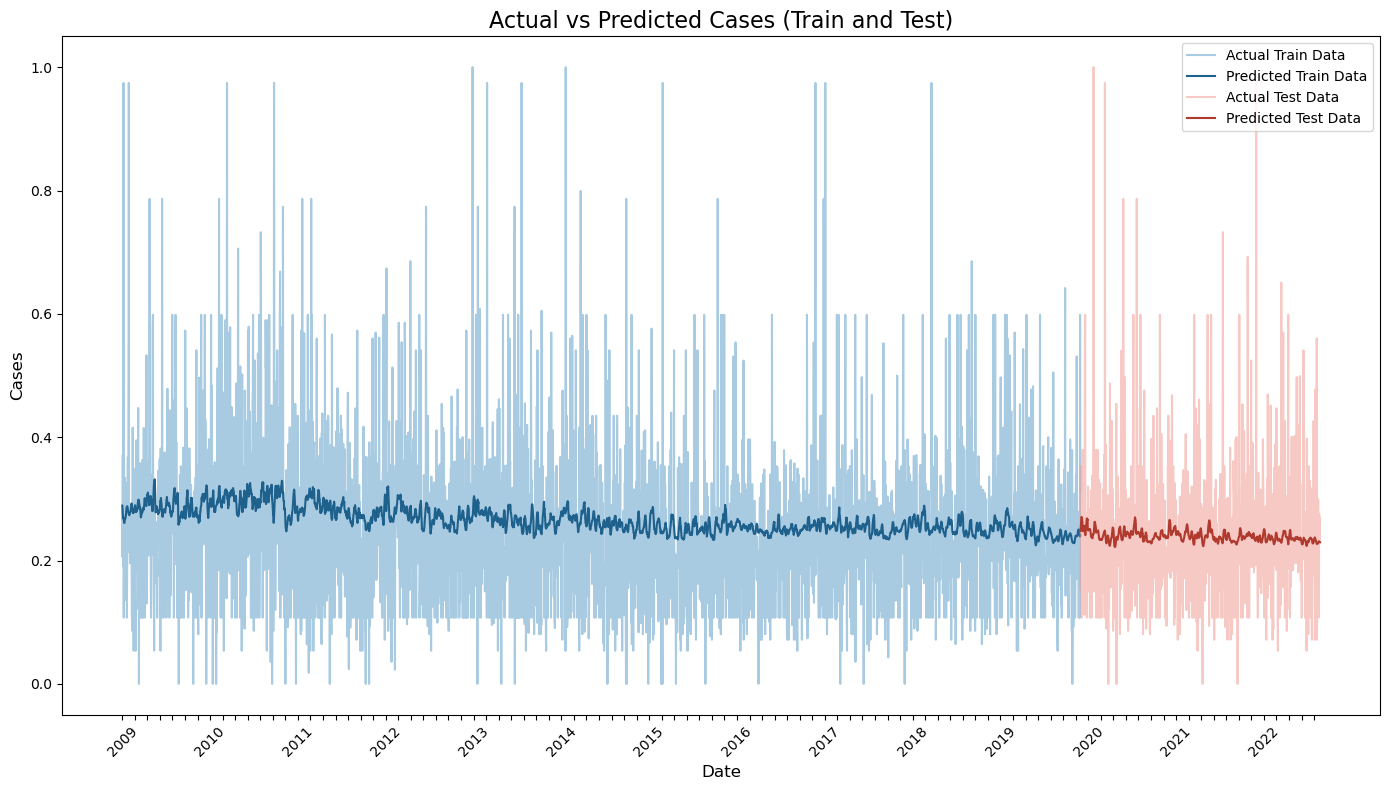

In [29]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted data for both training and test sets
plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(y_train, label='Actual Train Data', color='#5499C7', alpha=0.5)

# Plot predicted training data
y_pred_train = model.predict(X_train)
plt.plot(y_pred_train, label='Predicted Train Data', color='#1F618D')

# Plot test data
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual Test Data', color='#F1948A', alpha=0.5)

# Plot predicted test data
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred, label='Predicted Test Data', color='#B03A2E')

# Add labels and title
plt.xlabel('Date',fontsize=12)
plt.ylabel('Cases',fontsize=12)
plt.title('Actual vs Predicted Cases (Train and Test)',fontsize=16)
plt.legend()


ticks = np.arange(0, len(y_train) + len(y_test), 52)

# Create labels array
labels = []
year=2009

for i in range(len(ticks)):

    if i % 7 == 0:
        
        labels.append(year)
        year=year+1
    else:
        labels.append("")

plt.xticks(ticks=ticks, labels=labels, rotation=45)

# Show plot
plt.tight_layout()
plt.savefig("Documentacion\\figures\\lstm_pred_"+str(l_provincias)+".png",dpi=310)
plt.show()

In [30]:
# Número de semanas a predecir
n_weeks_to_predict = 124

# Predecir las próximas semanas
predictions = []
current_input = X_train[-1].copy()  # Usar la última secuencia de entrenamiento como punto de partida

for _ in range(n_weeks_to_predict):
    # Predecir el siguiente valor
    pred = model.predict(current_input[np.newaxis, ...])
    
    # Almacenar la predicción
    predictions.append(pred[0, 0])  # Se asume que la salida es un escalar

    # Actualizar current_input: 
    # Reemplazar la primera fila de current_input con la predicción
    current_input = np.roll(current_input, -1, axis=0)  # Mover las filas hacia arriba
    current_input[-1, 0] = pred[0, 0]  # Asignar la nueva predicción a la última fila

# Convertir las predicciones a un array de NumPy
predictions = np.array(predictions)

# Desescalar las predicciones
predictions_descaled = scaler.inverse_transform(predictions.reshape(-1, 1))

# Crear un rango de fechas para las predicciones
last_date = df_daily['fecha'].dt.to_timestamp().iloc[-1]  # Obtener la última fecha en el conjunto de datos
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=n_weeks_to_predict, freq='W-Mon')

# Crear un DataFrame para las predicciones
pred_df = pd.DataFrame(data={'fecha': future_dates, 'predicciones': predictions_descaled.flatten()})

# Mostrar las predicciones
print(pred_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

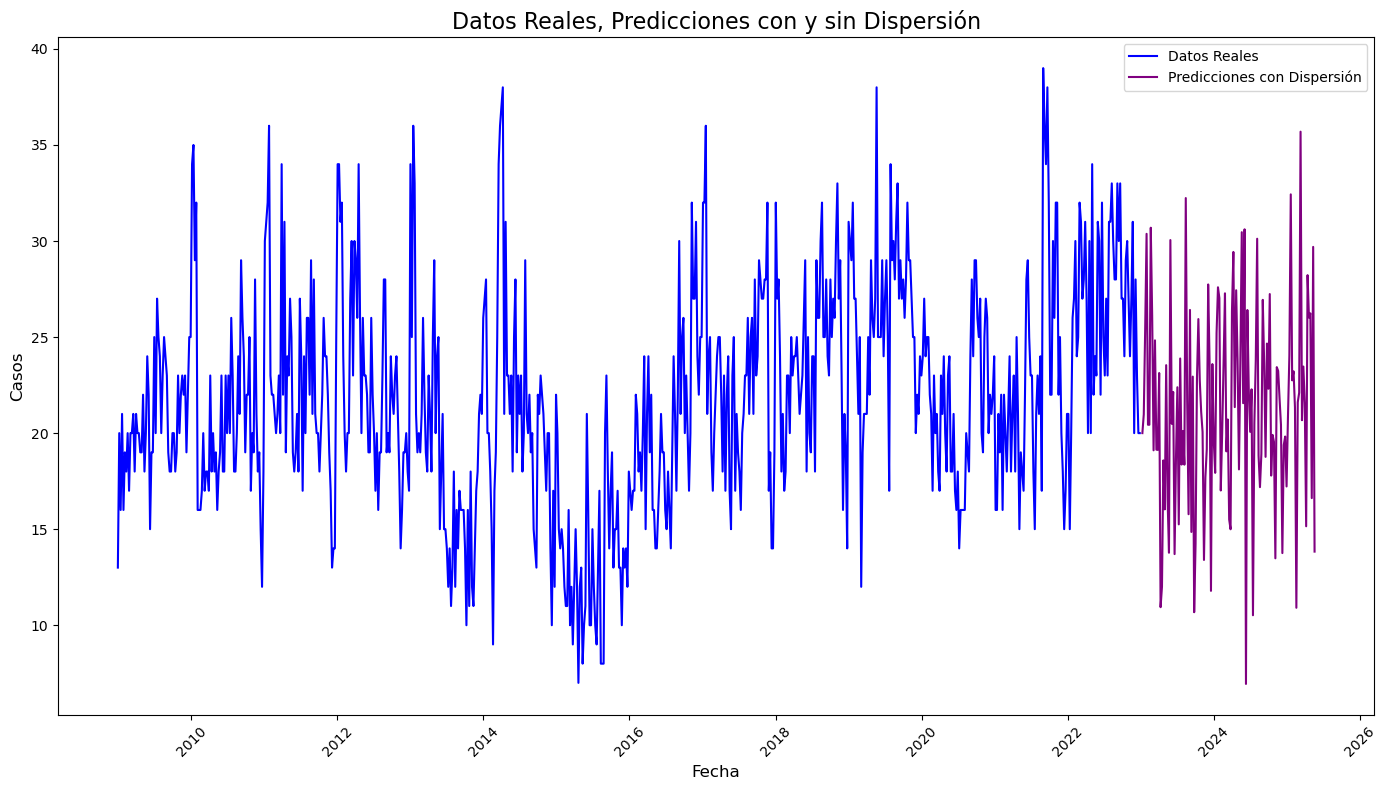

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Crear un DataFrame con los datos reales

df_f2['fecha']=pd.to_datetime(df_f2['fecha'])

df_daily = df_f2.groupby(df_f2['fecha'].dt.to_period('W-Mon'))['Casos'].sum().reset_index(name='cases')

scaler = MinMaxScaler(feature_range=(0, 1))
df_daily['cases_scaled'] = scaler.fit_transform(df_daily['cases'].values.reshape(-1, 1))

real_data = df_daily.copy()

pred_df['predicciones'] = predictions_descaled.flatten()

# Conectar el primer valor de la predicción con el último de los datos reales
pred_df['predicciones'][0] = real_data['cases'].iloc[-1]

# Crear una nueva serie con mayor dispersión
np.random.seed(42)  # Para reproducibilidad
dispersed_cases = np.random.normal(loc=real_data['cases'].mean(), 
                                   scale=real_data['cases'].std() * 1.0,  # Aumentar la dispersión
                                   size=len(pred_df))

# Asegurar que el primer valor de la serie de alta dispersión se conecte con el último de los datos reales
dispersed_cases[0] = real_data['cases'].iloc[-1]

# Crear una figura y un eje
plt.figure(figsize=(14, 8))

# Graficar los datos reales
plt.plot(real_data['fecha'].dt.to_timestamp(), real_data['cases'], label='Datos Reales', color='blue', markersize=3)

# # Graficar las predicciones
# plt.plot(pred_df['fecha'], pred_df['predicciones'], label='Predicciones sin Dispersión', color='red', markersize=5)

# Graficar la serie de datos con mayor dispersión
plt.plot(pred_df['fecha'], dispersed_cases, label='Predicciones con Dispersión', color='purple', markersize=5)

# Configurar etiquetas y título
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Casos', fontsize=12)
plt.title('Datos Reales, Predicciones con y sin Dispersión', fontsize=16)
plt.legend()
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.savefig("Documentacion\\figures\\real_vs_predicted_cases_with_dispersion.png", dpi=310)  # Guardar el gráfico
plt.show()


In [32]:
# Merge prom_dia_variables and df_ccc on 'fecha'

data_precovid=prom_dia_variables.loc[prom_dia_variables["fecha"]>"2020-01-01"]
df_ccc_precovid=df_ccc.loc[df_ccc["fecha"]>"2020-01-01"]
df_data_precovid = pd.merge(data_precovid, df_ccc_precovid , on=["fecha"], how="left")

# Set 'fecha' column as index and drop it from DataFrame
df_data_precovid.index = df_data_precovid["fecha"]
df_data_precovid = pd.DataFrame(df_data_precovid.drop("fecha", axis=1))


X_imputed_precovid = imputer_X.fit_transform(df_data_precovid.drop(columns=["casos_corr_2"]).values)
y_imputed_precovid = imputer_y.fit_transform(df_data_precovid["casos_corr_2"].values.reshape(-1, 1))

# Create sequences for LSTM input
X_seq_precovid, y_seq_precovid = create_sequences(pd.DataFrame(X_imputed_precovid), seq_length)

# Split data into training and test sets
split_ratio = 0.8
split = int(len(X_seq_precovid) * split_ratio)
X_train_precovid, X_test_precovid = X_seq_precovid[:split], X_seq_precovid[split:]
y_train_precovid, y_test_precovid = y_seq_precovid[:split], y_seq_precovid[split:]

# Reshape input dimensions for LSTM
X_train_precovid = np.reshape(X_train_precovid, (X_train_precovid.shape[0], X_train_precovid.shape[1], X_train_precovid.shape[2]))
X_test_precovid = np.reshape(X_test_precovid, (X_test_precovid.shape[0], X_test_precovid.shape[1], X_test_precovid.shape[2]))



load = 0

# Create and train the LSTM model
model_precovid = rnn_model(X_train_precovid,y_train_precovid, X_test_precovid,  y_test_precovid)

# Print model summary
model_precovid.summary()

# Evaluate the model using test data
y_pred_precovid = model_precovid.predict(X_test_precovid)
mse = mean_squared_error(y_test_precovid, y_pred_precovid)
print(f'Mean Squared Error: {mse}')

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0243 - val_loss: 0.0105
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0106 - val_loss: 0.0099
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0104 - val_loss: 0.0097
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0123 - val_loss: 0.0099
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0120 - val_loss: 0.0098
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0146 - val_loss: 0.0108
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0115 - val_loss: 0.0098
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0105 - val_loss: 0.0101
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0134 - val_loss: 0.0098
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0112 - val_loss: 0.0103
Epoch 12/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 10, 100)        │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 10, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 10, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 853,505 (3.26 MB)

 Trainable params: 284,501 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 569,004 (2.17 MB)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
Mean Squared Error: 0.009746478301754992


In [33]:




data_pre_covid = real_data[real_data['fecha'] <= '2019-12-31']

# Escalar los datos para usarlos en el modelo
scaler_pre_covid = MinMaxScaler(feature_range=(0, 1))
data_pre_covid['cases_scaled'] = scaler_pre_covid.fit_transform(data_pre_covid['cases'].values.reshape(-1, 1))

# Escalar los datos para usarlos en el modelo
scaler_pre_covid = MinMaxScaler(feature_range=(0, 1))
data_pre_covid['cases_scaled'] = scaler_pre_covid.fit_transform(data_pre_covid['cases'].values.reshape(-1, 1))

# Crear secuencias para el modelo LSTM usando los datos históricos
X_seq_pre_covid, y_seq_pre_covid = create_sequences(data_pre_covid[['cases_scaled']], seq_length)
data_pre_covid




,fecha,cases,cases_scaled
0,2008-12-30/2009-01-05,13.0,0.193548
1,2009-01-06/2009-01-12,20.0,0.419355
2,2009-01-13/2009-01-19,16.0,0.290323
3,2009-01-20/2009-01-26,21.0,0.451613
4,2009-01-27/2009-02-02,16.0,0.290323
...,...,...,...
570,2019-12-03/2019-12-09,20.0,0.419355
571,2019-12-10/2019-12-16,22.0,0.483871
572,2019-12-17/2019-12-23,21.0,0.451613
573,2019-12-24/2019-12-30,24.0,0.548387


In [34]:

# Dividir en conjuntos de entrenamiento y prueba (usaremos toda la data hasta 2019 para entrenar)
X_train_pre_covid = X_seq_pre_covid
y_train_pre_covid = y_seq_pre_covid

# Redimensionar para el modelo LSTM
X_train_pre_covid = np.reshape(X_train_pre_covid, (X_train_pre_covid.shape[0], X_train_pre_covid.shape[1], X_train_pre_covid.shape[2]))
X_train_pre_covid

array([], shape=(565, 10, 0), dtype=float64)

In [46]:
# Número de semanas a predecir
n_weeks_to_predict = 157

# Predecir las próximas semanas
predictions_precovid = []
current_input = X_train_precovid[-1].copy()  # Usar la última secuencia de entrenamiento como punto de partida

for _ in range(n_weeks_to_predict):
    # Predecir el siguiente valor
    pred = model_precovid.predict(current_input[np.newaxis, ...])
    
    # Almacenar la predicción
    predictions_precovid.append(pred[0, 0])  # Se asume que la salida es un escalar

    # Actualizar current_input: 
    # Reemplazar la primera fila de current_input con la predicción
    current_input = np.roll(current_input, -1, axis=0)  # Mover las filas hacia arriba
    current_input[-1, 0] = pred[0, 0]  # Asignar la nueva predicción a la última fila

# Convertir las predicciones a un array de NumPy
predictions_precovid= np.array(predictions_precovid)

# Desescalar las predicciones
predictions_descaled_precovid = scaler.inverse_transform(predictions_precovid.reshape(-1, 1))

# # Crear un rango de fechas para las predicciones
# last_date = promedio_dia.index[-1:][0].to_timestamp()  # Obtener la última fecha en el conjunto de datos
# future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=n_weeks_to_predict, freq='W-Mon')


future_weeks = 157
future_dates = pd.date_range(start='2020-01-01', periods=future_weeks, freq='W-Mon')
# Crear un DataFrame para las predicciones
predictions_pre_covid_df= pd.DataFrame(data={'fecha': future_dates, 'predicciones': predictions_descaled_precovid.flatten()})

# Mostrar las predicciones
print(pred_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

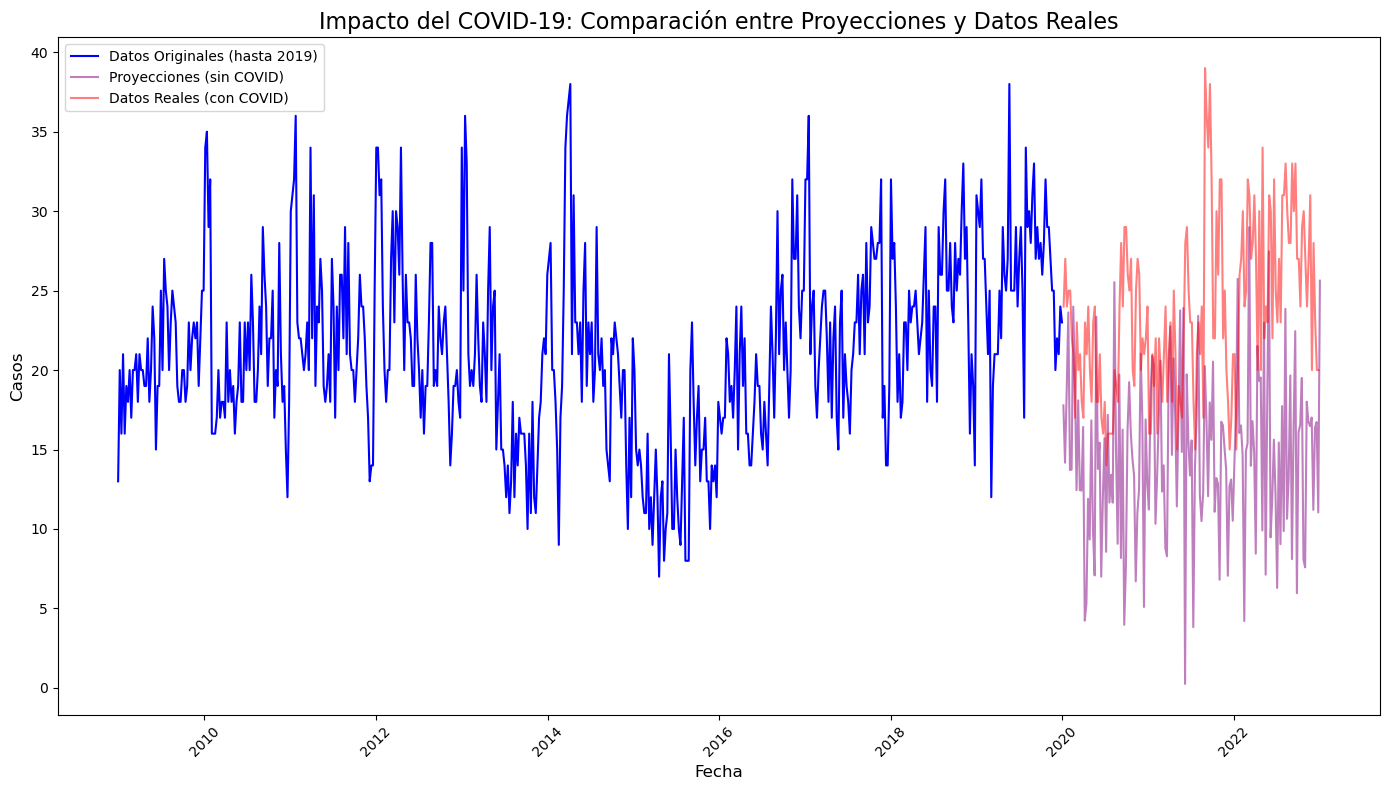

In [52]:

std_residuos = data_pre_covid['cases'].std()

# Generar ruido aleatorio con la misma desviación estándar
np.random.seed(42)
ruido = np.random.normal(loc=0, scale=std_residuos, size=predictions_pre_covid_df["predicciones"].shape)

# Agregar el ruido a las predicciones sin COVID
predictions_pre_covid_df["predicciones_dispersion"] =predictions_pre_covid_df["predicciones"]+ ruido




# Graficar los datos originales, las proyecciones pre-COVID y los datos reales después de 2020
plt.figure(figsize=(14, 8))

# Datos originales hasta 2019
plt.plot(data_pre_covid['fecha'].dt.to_timestamp(), data_pre_covid['cases'], label='Datos Originales (hasta 2019)', color='blue')

# Proyecciones para 2020 en adelante
plt.plot(predictions_pre_covid_df['fecha'], predictions_pre_covid_df["predicciones_dispersion"], label='Proyecciones (sin COVID)', color='purple',alpha=0.5)

# Datos reales a partir de 2020
plt.plot(real_data[real_data['fecha'] > '2019-12-31']['fecha'].dt.to_timestamp(), 
         real_data[real_data['fecha'] > '2019-12-31']['cases'], label='Datos Reales (con COVID)', color='red',alpha=0.5)

# Configurar etiquetas y título
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Casos', fontsize=12)
plt.title('Impacto del COVID-19: Comparación entre Proyecciones y Datos Reales', fontsize=16)
plt.legend()
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.savefig("Documentacion\\figures\\covid_impact_comparison.png", dpi=310)
plt.show()



In [58]:

print("Casos diarios post 2019")
"con COVID",round(real_data[real_data['fecha'] > '2019-12-31']['cases'].mean(),1),"sin COVID",round(predictions_pre_covid_df["predicciones_dispersion"].mean(),1)

Casos diarios post 2019


('con COVID', 23.6, 'sin COVID', 14.7)

In [ ]:
print("tr")